## Convert CSV to mseed

In [1]:
import os
import pandas as pd
import obspy as obs
import numpy as np

import matplotlib.pyplot as plt

from andbro__write_stream_to_sds import __write_stream_to_sds

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
path_to_data = data_path+"LNM2/data/wettzell/"

### Load Data

In [4]:
df = pd.read_csv(path_to_data+"luftdruck_wettzell.csv")

In [5]:
df

,epoch,p
0,2023-09-01 00:00:00+00,946.154
1,2023-09-01 00:01:00+00,946.165
2,2023-09-01 00:02:00+00,946.168
3,2023-09-01 00:03:00+00,946.168
4,2023-09-01 00:04:00+00,946.166
...,...,...
175390,2023-12-31 23:55:00+00,938.512
175391,2023-12-31 23:56:00+00,938.534
175392,2023-12-31 23:57:00+00,938.566
175393,2023-12-31 23:58:00+00,938.563


### Merge with Dummy Frame (to ensure constant sampling)

In [6]:
df_dummy = pd.DataFrame()

seconds = int(abs(obs.UTCDateTime(df.epoch.iloc[0][:-3]) - obs.UTCDateTime(df.epoch.iloc[-1][:-3])))

tt = []
for _n, _t in enumerate(np.arange(0, seconds+60, 60)):
    obst = obs.UTCDateTime(df.epoch.iloc[0][:-3]) + _t
    tt.append(f"{obst.date} {str(obst.time).split('.')[0]}+00")

df_dummy['epoch'] = tt

df_new = df_dummy.merge(df, how="outer", on="epoch")

In [7]:
# df_new[df_new.p.isna()]

### Create Stream and write to SDS

In [8]:
tr = obs.Trace()

Tdelta = 60

tr.data = df_new.p.to_numpy()
tr.stats.delta = Tdelta
tr.stats.starttime = obs.UTCDateTime(df.epoch.iloc[0][:-3])
tr.stats.network = "BW"
tr.stats.station = "WETR"
tr.stats.location = ""
tr.stats.channel = "BDO"

st = obs.Stream(traces=tr)

0.016666666666666666

In [10]:
for datetime in pd.date_range(str(st[0].stats.starttime.date), str(st[0].stats.endtime.date)):
    st_out = st.copy()
    st_out.trim(obs.UTCDateTime(datetime), obs.UTCDateTime(datetime)+86400-Tdelta)
    print(st_out)
    __write_stream_to_sds(st_out, path_to_data)

1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-01T00:00:00.000000Z - 2023-09-01T23:59:00.000000Z | 60.0 s, 1440 samples
 -> stored stream as: 2023/BW/WETR/BDO.D/BW.WETR..BDO.D.2023.244
1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-02T00:00:00.000000Z - 2023-09-02T23:59:00.000000Z | 60.0 s, 1440 samples
 -> stored stream as: 2023/BW/WETR/BDO.D/BW.WETR..BDO.D.2023.245
1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-03T00:00:00.000000Z - 2023-09-03T23:59:00.000000Z | 60.0 s, 1440 samples
 -> stored stream as: 2023/BW/WETR/BDO.D/BW.WETR..BDO.D.2023.246
1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-04T00:00:00.000000Z - 2023-09-04T23:59:00.000000Z | 60.0 s, 1440 samples
 -> stored stream as: 2023/BW/WETR/BDO.D/BW.WETR..BDO.D.2023.247
1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-05T00:00:00.000000Z - 2023-09-05T23:59:00.000000Z | 60.0 s, 1440 samples
 -> stored stream as: 2023/BW/WETR/BDO.D/BW.WETR..BDO.D.2023.248
1 Trace(s) in Stream:
BW.WETR..BDO | 2023-09-06T00:00:00.000000Z - 2023-09-06T23:59:0

In [16]:
from andbro__read_sds import __read_sds

In [73]:
tbeg, tend = obs.UTCDateTime("2023-12-31 00:00"), obs.UTCDateTime("2023-12-31 01:00")

rlas = __read_sds(archive_path+"romy_archive", "BW.RLAS..BJZ", tbeg, tend)
wetr = __read_sds(data_path+"LNM2/data/wettzell/", "BW.WETR..BDO", tbeg, tend)

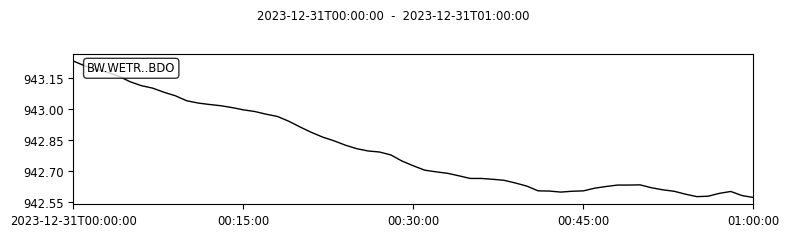

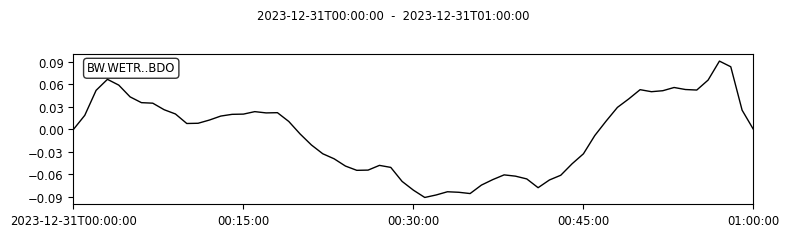

In [74]:
wetr.plot();

wetr.detrend("linear").detrend("demean")
wetr.taper(0.05)

wetr.plot();


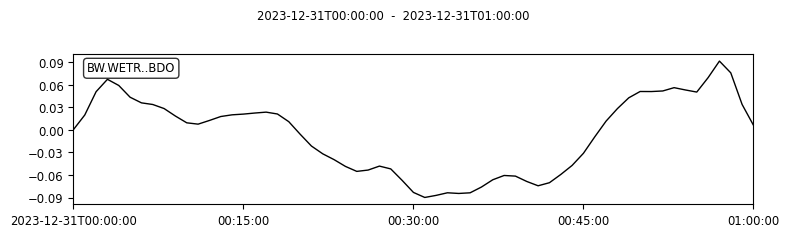

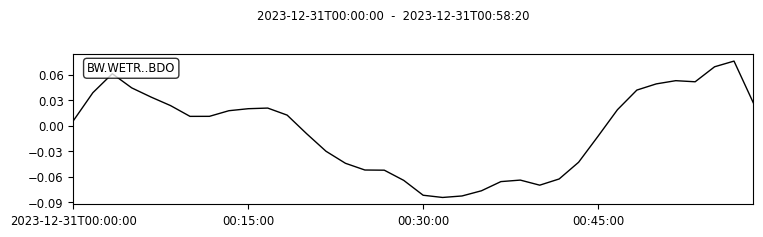

In [75]:

wetr.filter("lowpass", freq=0.005, corners=4, zerophase=True)
# wetr.filter("bandpass", freqmin=5e-4, freqmax=0.005, corners=4, zerophase=True)

wetr.plot();

wetr.resample(0.01, no_filter=True)

wetr.plot();
